In [1]:
import sys
import os
import torch
from torch.utils.data import DataLoader, random_split
from torch import nn, optim
from tqdm import tqdm
#from SEMPIDataLoader import ListenerSpeakerFeatureDataset
from multimodal_xattention import EarlyFusion, EarlyFusion2, EarlyFusion3, ListenerSpeakerHybridFusionSampling

import numpy as np
from types import SimpleNamespace

import matplotlib.pyplot as plt
from scipy.stats import pearsonr

d:\software\Anaconda\envs\eng_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Preparing dataset

In [2]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset

META_DATA_COLUMNS = ['frame', 'face_id', 'timestamp', 'confidence', 'success']

class ListenerSpeakerFeatureDataset(Dataset):
    def __init__(self, csv_path, frame_length=64, root_dir="", listener_video_features_size=1024, speaker_features_size=1024):
        self.data = pd.read_csv(csv_path)
        self.frame_length = frame_length
        self.root_dir = root_dir
        self.listener_video_features_size = listener_video_features_size  # Fixed size for listener video features
        self.speaker_features_size = speaker_features_size  # Fixed size for speaker features

    def __len__(self):
        return len(self.data)

    def load_audio_feature(self, path):
        full_path = os.path.join(self.root_dir, path)
        try:
            tensor = torch.load(full_path)
            #print(tensor.shape)
            if tensor.ndim == 1:
                tensor = tensor.unsqueeze(0)
            return tensor if tensor.ndim == 2 else tensor
        except Exception as e:
            print(f"Error loading audio feature from {full_path}:\n{e}")
            raise

    def load_openface_feature(self, path, exclude_cols=META_DATA_COLUMNS):
        full_path = os.path.join(self.root_dir, path)
        df = pd.read_csv(full_path)
        df = df.loc[:, ~df.columns.isin(exclude_cols)]
        return torch.tensor(df.values, dtype=torch.float32)

    def load_video_feature(self, path):
        full_path = os.path.join(self.root_dir, path)
        try:
            tensor = torch.load(full_path)
            if tensor.ndim == 1:
                tensor = tensor.unsqueeze(0)
            return tensor.T if tensor.ndim == 2 else tensor
        except Exception as e:
            print(f"Error loading video feature from {full_path}:\n{e}")
            raise

    def _pad_or_crop(self, feature_tensor, expected_size):
        """ Ensure the second dimension (features) is of the expected size """
        _, n_features = feature_tensor.shape
        if n_features < expected_size:
            padding = expected_size - n_features
            feature_tensor = torch.cat([feature_tensor, torch.zeros(feature_tensor.shape[0], padding)], dim=1)
        elif n_features > expected_size:
            feature_tensor = feature_tensor[:, :expected_size]
        return feature_tensor

    def _pad_or_crop_frames(self, feature_tensor):
        """ Padding or cropping the frames dimension to match frame_length """
        n_frames, n_features = feature_tensor.shape
        output = torch.zeros((self.frame_length, n_features))
        if n_frames >= self.frame_length:
            output[:] = feature_tensor[:self.frame_length]
        else:
            output[:n_frames] = feature_tensor
        return output.T

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        #listener_audio = self.load_audio_feature(row["listener_audio_path"])
        listener_video = self.load_video_feature(row["listener_video_path"])
        speaker_audio = self.load_audio_feature(row["speaker_audio_path"])
        #speaker_video = self.load_video_feature(row["speaker_video_path"])
        listener_openface = self.load_openface_feature(row["listener_openface_path"])
        #speaker_openface = self.load_openface_feature(row["speaker_openface_path"])

        listener_video = self._pad_or_crop(listener_video, self.listener_video_features_size)
        listener_video = self._pad_or_crop_frames(listener_video)

        #speaker_video = self._pad_or_crop(speaker_video, self.speaker_features_size)
        #speaker_video = self._pad_or_crop_frames(speaker_video)

        #listener_audio = self._pad_or_crop_frames(listener_audio)
        listener_openface = self._pad_or_crop_frames(listener_openface)

        speaker_audio = self._pad_or_crop_frames(speaker_audio)
        #speaker_openface = self._pad_or_crop_frames(speaker_openface)

        #features = (listener_video, speaker_audio)
        features = (listener_video, listener_openface, speaker_audio)
        #features = (listener_openface, speaker_audio)
        
        engagement = torch.tensor(float(row["engagement"]), dtype=torch.float32)
        pids = torch.tensor([0, 1], dtype=torch.int64)

        return {
            "features": features,
            "score": engagement,
            "pids": pids
        }

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = ListenerSpeakerFeatureDataset(
    csv_path="AudioVideo_Feature_Paths.csv",
    frame_length=64,
    root_dir="./",
)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, drop_last=False)


In [4]:
sample = dataset[0]
listener_video, listener_openface, speaker_audio = sample["features"]
listener_video_dim, listener_facial_dim, speaker_audio_dim = listener_video.shape[0], listener_openface.shape[0], speaker_audio.shape[0]
print(f"Listener video shape: {listener_video.shape}")
print(f"Listener openface shape: {listener_openface.shape}")
print(f"Speaker audio shape: {speaker_audio.shape}")

Listener video shape: torch.Size([1024, 64])
Listener openface shape: torch.Size([329, 64])
Speaker audio shape: torch.Size([768, 64])


# Test 1: Listener OpenFace + Speaker Speech

In [5]:
config = {
    'ckpt_root': './pretrained',
    'activation_fn': 'tanh',
    'extra_dropout': 0,
    'hidden_size': 8,
    'dropout': 0.2,
    'weight_decay': 0.01,
    'expnum': 8,
    'openfacefeat': 1,
    'openfacefeat_extramlp': 1,
    'openfacefeat_extramlp_dim': 8,
    'ablation': 8,
    'num_labels': 1
}

config = SimpleNamespace(**config)
model = EarlyFusion(config=config, pooling_factor=8).to(device).float()
print(model)

print(f"Parameters:")
print(f"activation_fn: {config.activation_fn}")
print(f"hidden_size: {config.hidden_size}")
print(f"dropout: {config.dropout}")
print(f"weight_decay: {config.weight_decay}")
print(f"num_labels: {config.num_labels}")
print(f"pooling_factor: {model.pooling_factor}")

# Count trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {trainable_params}")


EarlyFusion(
  (openface_mlp): Sequential(
    (0): Linear(in_features=329, out_features=8, bias=True)
    (1): Tanh()
  )
  (audio_mlp): Sequential(
    (0): Linear(in_features=768, out_features=8, bias=True)
    (1): Tanh()
  )
  (cross_attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=8, out_features=8, bias=True)
  )
  (fusion_mlp): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): Tanh()
  )
  (out): Classifier(
    (dropout): Dropout(p=0.2, inplace=False)
    (fc1): Linear(in_features=64, out_features=8, bias=True)
    (fc2): Linear(in_features=8, out_features=8, bias=True)
    (fc3): Linear(in_features=8, out_features=1, bias=True)
    (activation_fn): Tanh()
  )
)
Parameters:
activation_fn: tanh
hidden_size: 8
dropout: 0.2
weight_decay: 0.01
num_labels: 1
pooling_factor: 8
Total trainable parameters: 17937


In [6]:
def compute_ccc_batched(y_pred, y_true):

    y_true_np = y_true.flatten()
    y_pred_np = y_pred.flatten()
    mean_true = np.mean(y_true_np)
    mean_pred = np.mean(y_pred_np)
    std_true = np.std(y_true_np)
    std_pred = np.std(y_pred_np)

    rho, _ = pearsonr(y_true_np, y_pred_np)

    # Calculate CCC
    ccc = (2 * rho * std_true * std_pred) / (std_true**2 + std_pred**2 + (mean_true - mean_pred)**2)
    
    return ccc

def compute_pearson_correlation_batched(y_pred, y_true):
 
    y_true_np = y_true.flatten()
    y_pred_np = y_pred.flatten()

    # Calculate PCC
    rho, _ = pearsonr(y_true_np, y_pred_np)

    return rho

In [7]:
# Training settings
num_epochs = 50
learning_rate = 1e-4
best_model_path = 'best_early_fusion_model.pth'

criterion = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=config.weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)

# Training tracking
best_val_ccc = -float('inf')
no_improve_count = 0
train_losses = []
val_losses = []
val_cccs = []
val_pccs = []

d:\software\Anaconda\envs\eng_env\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [8]:
try:
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        # Training:
        model.train()
        total_train_loss = 0
        
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]", leave=False):

            _, listener_feat, speaker_feat = batch["features"]
            engagement = batch["score"]
            
            speaker_feat = speaker_feat.to(device).float()
            listener_feat = listener_feat.to(device).float()
            engagement = engagement.to(device)
            engagement = engagement.view(-1, 1)
            optimizer.zero_grad()
            
            # Create a list of listener features with transposed dimensions
            listener_feat_list = []
            for i in range(listener_feat.size(0)):
                listener_feat_list.append(listener_feat[i])
            
            output = model(audio_paths=speaker_feat, openfacefeat_=listener_feat_list)
            loss = criterion(output, engagement)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        
        # Calculate average training loss
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Training Loss: {avg_train_loss:.4f}")
        
        # Validation:
        model.eval()
        val_loss = 0
        val_preds = []
        val_targets = []
        
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]", leave=False):

                _, listener_feat, speaker_feat = batch["features"]
                engagement = batch["score"]
                
                speaker_feat = speaker_feat.to(device)
                listener_feat = listener_feat.to(device)
                engagement = engagement.to(device)
                engagement = engagement.view(-1, 1)

                # Create a list of listener features with transposed dimensions
                listener_feat_list = []
                for i in range(listener_feat.size(0)):
                    listener_feat_list.append(listener_feat[i])
                
                output = model(audio_paths=speaker_feat, openfacefeat_=listener_feat_list)
                loss = criterion(output, engagement)
                val_loss += loss.item() * engagement.size(0)
                
                # Store predictions and targets for metrics
                val_preds.append(output.cpu())
                val_targets.append(engagement.cpu())
        
        # Calculate average validation loss
        avg_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)
        
        # Calculate metrics
        val_preds_combined = torch.cat(val_preds).numpy()
        val_targets_combined = torch.cat(val_targets).numpy()
        
        val_ccc = compute_ccc_batched(val_preds_combined, val_targets_combined)
        val_pcc = compute_pearson_correlation_batched(val_preds_combined, val_targets_combined)
        
        val_cccs.append(val_ccc)
        val_pccs.append(val_pcc)
        
        print(f"Validation Loss: {avg_val_loss:.4f}, CCC: {val_ccc:.4f}, PCC: {val_pcc:.4f}")
        
        # Update learning rate
        scheduler.step(avg_val_loss)
        
        # Check if this is the best model
        if val_ccc > best_val_ccc:
            best_val_ccc = val_ccc
            # Save model
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': avg_val_loss,
                'val_ccc': val_ccc,
                'val_pcc': val_pcc,
                'config': config,
            }, best_model_path)
            print(f"✓ Saved new best model with validation CCC: {val_ccc:.4f}")

except KeyboardInterrupt:
    print("Training interrupted by user")

Epoch 1/50


Training Loss: 0.0199


Validation Loss: 0.0163, CCC: 0.1274, PCC: 0.3065
✓ Saved new best model with validation CCC: 0.1274
Epoch 2/50


Training Loss: 0.0177


Validation Loss: 0.0160, CCC: 0.1717, PCC: 0.3228
✓ Saved new best model with validation CCC: 0.1717
Epoch 3/50


Training Loss: 0.0173


Validation Loss: 0.0157, CCC: 0.1933, PCC: 0.3485
✓ Saved new best model with validation CCC: 0.1933
Epoch 4/50


Training Loss: 0.0170


Validation Loss: 0.0152, CCC: 0.2186, PCC: 0.3887
✓ Saved new best model with validation CCC: 0.2186
Epoch 5/50


Training Loss: 0.0162


Validation Loss: 0.0152, CCC: 0.2582, PCC: 0.3882
✓ Saved new best model with validation CCC: 0.2582
Epoch 6/50


Training Loss: 0.0155


Validation Loss: 0.0152, CCC: 0.2779, PCC: 0.4047
✓ Saved new best model with validation CCC: 0.2779
Epoch 7/50


Training Loss: 0.0152


Validation Loss: 0.0146, CCC: 0.2944, PCC: 0.4236
✓ Saved new best model with validation CCC: 0.2944
Epoch 8/50


Training Loss: 0.0148


Validation Loss: 0.0146, CCC: 0.3141, PCC: 0.4257
✓ Saved new best model with validation CCC: 0.3141
Epoch 9/50


Training Loss: 0.0142


Validation Loss: 0.0145, CCC: 0.3270, PCC: 0.4338
✓ Saved new best model with validation CCC: 0.3270
Epoch 10/50


Training Loss: 0.0142


Validation Loss: 0.0143, CCC: 0.3368, PCC: 0.4468
✓ Saved new best model with validation CCC: 0.3368
Epoch 11/50


Training Loss: 0.0134


Validation Loss: 0.0142, CCC: 0.3672, PCC: 0.4571
✓ Saved new best model with validation CCC: 0.3672
Epoch 12/50


Training Loss: 0.0129


Validation Loss: 0.0145, CCC: 0.3710, PCC: 0.4542
✓ Saved new best model with validation CCC: 0.3710
Epoch 13/50


Training Loss: 0.0130


Validation Loss: 0.0145, CCC: 0.3646, PCC: 0.4504
Epoch 14/50


Training Loss: 0.0126


Validation Loss: 0.0144, CCC: 0.3757, PCC: 0.4491
✓ Saved new best model with validation CCC: 0.3757
Epoch 15/50


Training Loss: 0.0122


Validation Loss: 0.0143, CCC: 0.3813, PCC: 0.4600
✓ Saved new best model with validation CCC: 0.3813
Epoch 16/50


Training Loss: 0.0121


Validation Loss: 0.0143, CCC: 0.3739, PCC: 0.4501
Epoch 17/50


Training Loss: 0.0123


Validation Loss: 0.0144, CCC: 0.3880, PCC: 0.4555
✓ Saved new best model with validation CCC: 0.3880
Epoch 18/50


Training Loss: 0.0115


Validation Loss: 0.0144, CCC: 0.3968, PCC: 0.4584
✓ Saved new best model with validation CCC: 0.3968
Epoch 19/50


Training Loss: 0.0110


Validation Loss: 0.0144, CCC: 0.3950, PCC: 0.4551
Epoch 20/50


Training Loss: 0.0107


Validation Loss: 0.0145, CCC: 0.3995, PCC: 0.4598
✓ Saved new best model with validation CCC: 0.3995
Epoch 21/50


Training Loss: 0.0105


Validation Loss: 0.0145, CCC: 0.4072, PCC: 0.4590
✓ Saved new best model with validation CCC: 0.4072
Epoch 22/50


Training Loss: 0.0109


Validation Loss: 0.0147, CCC: 0.4017, PCC: 0.4559
Epoch 23/50


Training Loss: 0.0106


Validation Loss: 0.0145, CCC: 0.4031, PCC: 0.4546
Epoch 24/50


Training Loss: 0.0104


Validation Loss: 0.0145, CCC: 0.4027, PCC: 0.4552
Epoch 25/50


Training Loss: 0.0106


Validation Loss: 0.0149, CCC: 0.3991, PCC: 0.4579
Epoch 26/50


Training Loss: 0.0101


Validation Loss: 0.0146, CCC: 0.4032, PCC: 0.4547
Epoch 27/50


Training Loss: 0.0104


Validation Loss: 0.0146, CCC: 0.4053, PCC: 0.4531
Epoch 28/50


Training Loss: 0.0102


Validation Loss: 0.0148, CCC: 0.4087, PCC: 0.4567
✓ Saved new best model with validation CCC: 0.4087
Epoch 29/50


Training Loss: 0.0103


Validation Loss: 0.0146, CCC: 0.4089, PCC: 0.4557
✓ Saved new best model with validation CCC: 0.4089
Epoch 30/50


Training Loss: 0.0101


Validation Loss: 0.0146, CCC: 0.4109, PCC: 0.4560
✓ Saved new best model with validation CCC: 0.4109
Epoch 31/50


Training Loss: 0.0100


Validation Loss: 0.0147, CCC: 0.4104, PCC: 0.4569
Epoch 32/50


Training Loss: 0.0098


Validation Loss: 0.0147, CCC: 0.4136, PCC: 0.4569
✓ Saved new best model with validation CCC: 0.4136
Epoch 33/50


Training Loss: 0.0102


Validation Loss: 0.0148, CCC: 0.4110, PCC: 0.4547
Epoch 34/50


Training Loss: 0.0100


Validation Loss: 0.0147, CCC: 0.4139, PCC: 0.4556
✓ Saved new best model with validation CCC: 0.4139
Epoch 35/50


Training Loss: 0.0099


Validation Loss: 0.0147, CCC: 0.4132, PCC: 0.4564
Epoch 36/50


Training Loss: 0.0101


Validation Loss: 0.0147, CCC: 0.4126, PCC: 0.4551
Epoch 37/50


Training Loss: 0.0098


Validation Loss: 0.0147, CCC: 0.4145, PCC: 0.4556
✓ Saved new best model with validation CCC: 0.4145
Epoch 38/50


Training Loss: 0.0097


Validation Loss: 0.0147, CCC: 0.4154, PCC: 0.4569
✓ Saved new best model with validation CCC: 0.4154
Epoch 39/50


Training Loss: 0.0096


Validation Loss: 0.0147, CCC: 0.4156, PCC: 0.4561
✓ Saved new best model with validation CCC: 0.4156
Epoch 40/50


Training Loss: 0.0097


Validation Loss: 0.0148, CCC: 0.4124, PCC: 0.4564
Epoch 41/50


Training Loss: 0.0098


Validation Loss: 0.0147, CCC: 0.4129, PCC: 0.4555
Epoch 42/50


Training Loss: 0.0098


Validation Loss: 0.0147, CCC: 0.4132, PCC: 0.4552
Epoch 43/50


Training Loss: 0.0096


Validation Loss: 0.0147, CCC: 0.4139, PCC: 0.4553
Epoch 44/50


Training Loss: 0.0097


Validation Loss: 0.0147, CCC: 0.4133, PCC: 0.4549
Epoch 45/50


Training Loss: 0.0096


Validation Loss: 0.0147, CCC: 0.4134, PCC: 0.4553
Epoch 46/50


Training Loss: 0.0099


Validation Loss: 0.0148, CCC: 0.4136, PCC: 0.4552
Epoch 47/50


Training Loss: 0.0100


Validation Loss: 0.0148, CCC: 0.4136, PCC: 0.4552
Epoch 48/50


Training Loss: 0.0097


Validation Loss: 0.0148, CCC: 0.4134, PCC: 0.4551
Epoch 49/50


Training Loss: 0.0097


Validation Loss: 0.0148, CCC: 0.4136, PCC: 0.4550
Epoch 50/50


Training Loss: 0.0098


Validation Loss: 0.0148, CCC: 0.4136, PCC: 0.4549


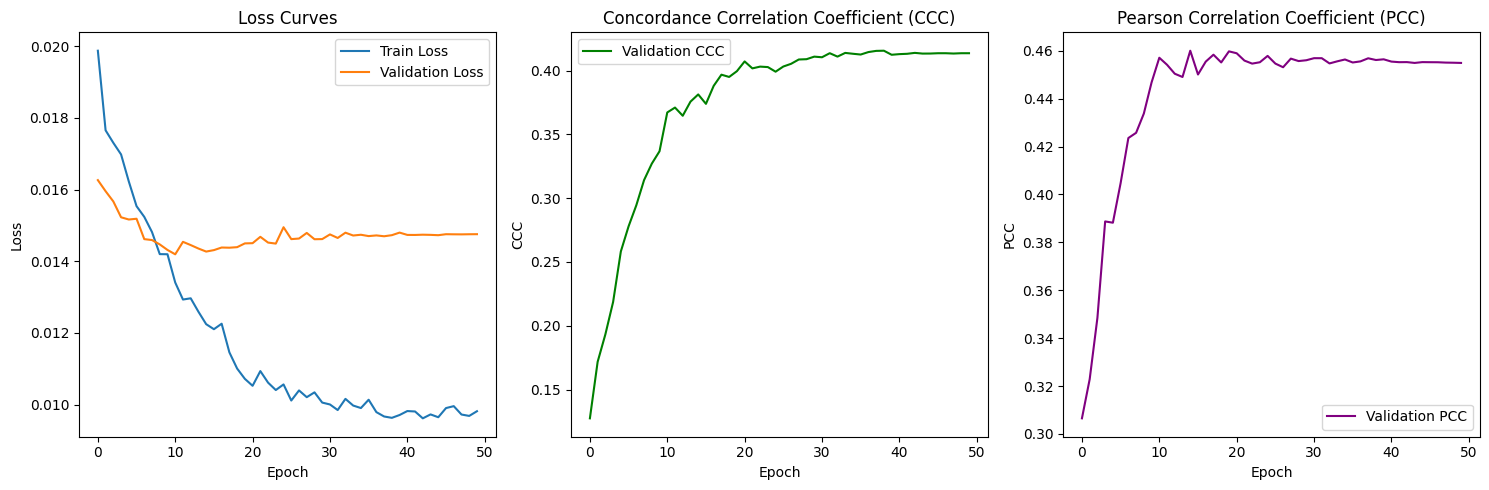

In [ ]:
# Final visualization
plt.figure(figsize=(15, 5))

# Plot 1: Loss curves
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

# Plot 2: CCC curve
plt.subplot(1, 3, 2)
plt.plot(val_cccs, label='Validation CCC', color='green')
plt.xlabel('Epoch')
plt.ylabel('CCC')
plt.legend()
plt.title('Concordance Correlation Coefficient (CCC)')

# Plot 3: PCC curve
plt.subplot(1, 3, 3)
plt.plot(val_pccs, label='Validation PCC', color='purple')
plt.xlabel('Epoch')
plt.ylabel('PCC')
plt.legend()
plt.title('Pearson Correlation Coefficient (PCC)')

plt.tight_layout()
plt.savefig('m2_openface_audio.png')
plt.show()

In [10]:
# Load the best model for evaluation
if os.path.exists(best_model_path):
    checkpoint = torch.load(best_model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded best model from epoch {checkpoint['epoch']+1} with:")
    print(f"- Validation Loss: {checkpoint['val_loss']:.4f}")
    print(f"- Validation CCC: {checkpoint['val_ccc']:.4f}")
    print(f"- Validation PCC: {checkpoint['val_pcc']:.4f}")


Loaded best model from epoch 39 with:
- Validation Loss: 0.0147
- Validation CCC: 0.4156
- Validation PCC: 0.4561


# Test 2: Listener Video + Speaker Speech

In [11]:
config = {
    'ckpt_root': './pretrained',
    'activation_fn': 'tanh',
    'extra_dropout': 0,
    'hidden_size': 8,
    'dropout': 0.2,
    'weight_decay': 0.01,
    'expnum': 8,
    'openfacefeat': 1,
    'openfacefeat_extramlp': 1,
    'openfacefeat_extramlp_dim': 8,
    'ablation': 8,
    'num_labels': 1
}

config = SimpleNamespace(**config)
model = EarlyFusion2(config=config, pooling_factor=8).to(device).float()
print(model)

print(f"Parameters:")
print(f"activation_fn: {config.activation_fn}")
print(f"hidden_size: {config.hidden_size}")
print(f"dropout: {config.dropout}")
print(f"weight_decay: {config.weight_decay}")
print(f"num_labels: {config.num_labels}")
print(f"pooling_factor: {model.pooling_factor}")

# Count trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {trainable_params}")


EarlyFusion2(
  (video_mlp): Sequential(
    (0): Linear(in_features=1024, out_features=8, bias=True)
    (1): Tanh()
  )
  (audio_mlp): Sequential(
    (0): Linear(in_features=768, out_features=8, bias=True)
    (1): Tanh()
  )
  (cross_attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=8, out_features=8, bias=True)
  )
  (fusion_mlp): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): Tanh()
  )
  (out): Classifier(
    (dropout): Dropout(p=0.2, inplace=False)
    (fc1): Linear(in_features=64, out_features=8, bias=True)
    (fc2): Linear(in_features=8, out_features=8, bias=True)
    (fc3): Linear(in_features=8, out_features=1, bias=True)
    (activation_fn): Tanh()
  )
)
Parameters:
activation_fn: tanh
hidden_size: 8
dropout: 0.2
weight_decay: 0.01
num_labels: 1
pooling_factor: 8
Total trainable parameters: 23497


In [12]:
def compute_ccc_batched(y_pred, y_true):

    y_true_np = y_true.flatten()
    y_pred_np = y_pred.flatten()
    mean_true = np.mean(y_true_np)
    mean_pred = np.mean(y_pred_np)
    std_true = np.std(y_true_np)
    std_pred = np.std(y_pred_np)

    rho, _ = pearsonr(y_true_np, y_pred_np)

    # Calculate CCC
    ccc = (2 * rho * std_true * std_pred) / (std_true**2 + std_pred**2 + (mean_true - mean_pred)**2)
    
    return ccc

def compute_pearson_correlation_batched(y_pred, y_true):
 
    y_true_np = y_true.flatten()
    y_pred_np = y_pred.flatten()

    # Calculate PCC
    rho, _ = pearsonr(y_true_np, y_pred_np)

    return rho

In [13]:
# Training settings
num_epochs = 50
learning_rate = 1e-4
best_model_path = 'best_early_fusion_model2.pth'

criterion = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=config.weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)

# Training tracking
best_val_ccc = -float('inf')
no_improve_count = 0
train_losses = []
val_losses = []
val_cccs = []
val_pccs = []

d:\software\Anaconda\envs\eng_env\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [14]:
try:
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        # Training:
        model.train()
        total_train_loss = 0
        
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]", leave=False):

            listener_feat, _, speaker_feat = batch["features"]
            engagement = batch["score"]
            
            speaker_feat = speaker_feat.to(device).float()
            listener_feat = listener_feat.to(device).float()
            engagement = engagement.to(device)
            engagement = engagement.view(-1, 1)
            optimizer.zero_grad()
            
            output = model(audio_paths=speaker_feat, video_paths=listener_feat)
            loss = criterion(output, engagement)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        
        # Calculate average training loss
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Training Loss: {avg_train_loss:.4f}")
        
        # Validation:
        model.eval()
        val_loss = 0
        val_preds = []
        val_targets = []
        
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]", leave=False):

                listener_feat, _, speaker_feat = batch["features"]
                engagement = batch["score"]
                
                speaker_feat = speaker_feat.to(device)
                listener_feat = listener_feat.to(device)
                engagement = engagement.to(device)
                engagement = engagement.view(-1, 1)

                output = model(audio_paths=speaker_feat, video_paths=listener_feat)
                loss = criterion(output, engagement)
                val_loss += loss.item() * engagement.size(0)
                
                # Store predictions and targets for metrics
                val_preds.append(output.cpu())
                val_targets.append(engagement.cpu())
        
        # Calculate average validation loss
        avg_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)
        
        # Calculate metrics
        val_preds_combined = torch.cat(val_preds).numpy()
        val_targets_combined = torch.cat(val_targets).numpy()
        
        val_ccc = compute_ccc_batched(val_preds_combined, val_targets_combined)
        val_pcc = compute_pearson_correlation_batched(val_preds_combined, val_targets_combined)
        
        val_cccs.append(val_ccc)
        val_pccs.append(val_pcc)
        
        print(f"Validation Loss: {avg_val_loss:.4f}, CCC: {val_ccc:.4f}, PCC: {val_pcc:.4f}")
        
        # Update learning rate
        scheduler.step(avg_val_loss)
        
        # Check if this is the best model
        if val_ccc > best_val_ccc:
            best_val_ccc = val_ccc
            # Save model
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': avg_val_loss,
                'val_ccc': val_ccc,
                'val_pcc': val_pcc,
                'config': config,
            }, best_model_path)
            print(f"✓ Saved new best model with validation CCC: {val_ccc:.4f}")

except KeyboardInterrupt:
    print("Training interrupted by user")

Epoch 1/50


Epoch 1 [Train]:   0%|          | 0/132 [00:00<?, ?it/s]

Training Loss: 0.0236


Validation Loss: 0.0177, CCC: 0.0084, PCC: 0.0725
✓ Saved new best model with validation CCC: 0.0084
Epoch 2/50


Training Loss: 0.0208


Validation Loss: 0.0175, CCC: 0.0184, PCC: 0.1322
✓ Saved new best model with validation CCC: 0.0184
Epoch 3/50


Training Loss: 0.0202


Validation Loss: 0.0175, CCC: 0.0291, PCC: 0.1724
✓ Saved new best model with validation CCC: 0.0291
Epoch 4/50


Training Loss: 0.0201


Validation Loss: 0.0172, CCC: 0.0446, PCC: 0.1972
✓ Saved new best model with validation CCC: 0.0446
Epoch 5/50


Training Loss: 0.0194


Validation Loss: 0.0171, CCC: 0.0568, PCC: 0.2157
✓ Saved new best model with validation CCC: 0.0568
Epoch 6/50


Training Loss: 0.0195


Validation Loss: 0.0170, CCC: 0.0775, PCC: 0.2351
✓ Saved new best model with validation CCC: 0.0775
Epoch 7/50


Training Loss: 0.0186


Validation Loss: 0.0168, CCC: 0.0968, PCC: 0.2447
✓ Saved new best model with validation CCC: 0.0968
Epoch 8/50


Training Loss: 0.0183


Validation Loss: 0.0166, CCC: 0.1212, PCC: 0.2595
✓ Saved new best model with validation CCC: 0.1212
Epoch 9/50


Training Loss: 0.0176


Validation Loss: 0.0165, CCC: 0.1463, PCC: 0.2758
✓ Saved new best model with validation CCC: 0.1463
Epoch 10/50


Training Loss: 0.0169


Validation Loss: 0.0164, CCC: 0.1623, PCC: 0.2850
✓ Saved new best model with validation CCC: 0.1623
Epoch 11/50


Training Loss: 0.0166


Validation Loss: 0.0163, CCC: 0.1809, PCC: 0.3007
✓ Saved new best model with validation CCC: 0.1809
Epoch 12/50


Training Loss: 0.0165


Validation Loss: 0.0162, CCC: 0.2024, PCC: 0.3160
✓ Saved new best model with validation CCC: 0.2024
Epoch 13/50


Training Loss: 0.0159


Validation Loss: 0.0161, CCC: 0.2108, PCC: 0.3160
✓ Saved new best model with validation CCC: 0.2108
Epoch 14/50


Training Loss: 0.0158


Validation Loss: 0.0162, CCC: 0.2313, PCC: 0.3265
✓ Saved new best model with validation CCC: 0.2313
Epoch 15/50


Training Loss: 0.0147


Validation Loss: 0.0160, CCC: 0.2406, PCC: 0.3305
✓ Saved new best model with validation CCC: 0.2406
Epoch 16/50


Training Loss: 0.0147


Validation Loss: 0.0161, CCC: 0.2444, PCC: 0.3293
✓ Saved new best model with validation CCC: 0.2444
Epoch 17/50


Training Loss: 0.0146


Validation Loss: 0.0161, CCC: 0.2568, PCC: 0.3375
✓ Saved new best model with validation CCC: 0.2568
Epoch 18/50


Training Loss: 0.0145


Validation Loss: 0.0163, CCC: 0.2633, PCC: 0.3373
✓ Saved new best model with validation CCC: 0.2633
Epoch 19/50


Training Loss: 0.0143


Validation Loss: 0.0163, CCC: 0.2680, PCC: 0.3360
✓ Saved new best model with validation CCC: 0.2680
Epoch 20/50


Training Loss: 0.0135


Validation Loss: 0.0165, CCC: 0.2708, PCC: 0.3326
✓ Saved new best model with validation CCC: 0.2708
Epoch 21/50


Training Loss: 0.0137


Validation Loss: 0.0168, CCC: 0.2691, PCC: 0.3331
Epoch 22/50


Training Loss: 0.0134


Validation Loss: 0.0166, CCC: 0.2718, PCC: 0.3299
✓ Saved new best model with validation CCC: 0.2718
Epoch 23/50


Training Loss: 0.0137


Validation Loss: 0.0170, CCC: 0.2676, PCC: 0.3294
Epoch 24/50


Training Loss: 0.0133


Validation Loss: 0.0167, CCC: 0.2718, PCC: 0.3270
Epoch 25/50


Training Loss: 0.0127


Validation Loss: 0.0169, CCC: 0.2765, PCC: 0.3280
✓ Saved new best model with validation CCC: 0.2765
Epoch 26/50


Training Loss: 0.0129


Validation Loss: 0.0170, CCC: 0.2761, PCC: 0.3272
Epoch 27/50


Training Loss: 0.0130


Validation Loss: 0.0169, CCC: 0.2787, PCC: 0.3274
✓ Saved new best model with validation CCC: 0.2787
Epoch 28/50


Training Loss: 0.0126


Validation Loss: 0.0170, CCC: 0.2774, PCC: 0.3269
Epoch 29/50


Training Loss: 0.0123


Validation Loss: 0.0169, CCC: 0.2791, PCC: 0.3255
✓ Saved new best model with validation CCC: 0.2791
Epoch 30/50


Training Loss: 0.0122


Validation Loss: 0.0171, CCC: 0.2790, PCC: 0.3260
Epoch 31/50


Training Loss: 0.0123


Validation Loss: 0.0170, CCC: 0.2800, PCC: 0.3247
✓ Saved new best model with validation CCC: 0.2800
Epoch 32/50


Training Loss: 0.0125


Validation Loss: 0.0172, CCC: 0.2803, PCC: 0.3245
✓ Saved new best model with validation CCC: 0.2803
Epoch 33/50


Training Loss: 0.0125


Validation Loss: 0.0172, CCC: 0.2789, PCC: 0.3230
Epoch 34/50


Training Loss: 0.0126


Validation Loss: 0.0172, CCC: 0.2791, PCC: 0.3219
Epoch 35/50


Training Loss: 0.0124


Validation Loss: 0.0172, CCC: 0.2796, PCC: 0.3214
Epoch 36/50


Training Loss: 0.0122


Validation Loss: 0.0172, CCC: 0.2796, PCC: 0.3212
Epoch 37/50


Training Loss: 0.0119


Validation Loss: 0.0172, CCC: 0.2798, PCC: 0.3210
Epoch 38/50


Training Loss: 0.0126


Validation Loss: 0.0172, CCC: 0.2792, PCC: 0.3206
Epoch 39/50


Training Loss: 0.0123


Validation Loss: 0.0173, CCC: 0.2800, PCC: 0.3205
Epoch 40/50


Training Loss: 0.0121


Validation Loss: 0.0173, CCC: 0.2798, PCC: 0.3206
Epoch 41/50


Training Loss: 0.0123


Validation Loss: 0.0173, CCC: 0.2794, PCC: 0.3203
Epoch 42/50


Training Loss: 0.0116


Validation Loss: 0.0173, CCC: 0.2797, PCC: 0.3201
Epoch 43/50


Training Loss: 0.0119


Validation Loss: 0.0173, CCC: 0.2798, PCC: 0.3199
Epoch 44/50


Training Loss: 0.0121


Validation Loss: 0.0173, CCC: 0.2797, PCC: 0.3199
Epoch 45/50


Training Loss: 0.0121


Validation Loss: 0.0173, CCC: 0.2800, PCC: 0.3199
Epoch 46/50


Training Loss: 0.0122


Validation Loss: 0.0173, CCC: 0.2799, PCC: 0.3199
Epoch 47/50


Training Loss: 0.0121


Validation Loss: 0.0173, CCC: 0.2800, PCC: 0.3198
Epoch 48/50


Training Loss: 0.0124


Validation Loss: 0.0173, CCC: 0.2799, PCC: 0.3197
Epoch 49/50


Training Loss: 0.0120


Validation Loss: 0.0173, CCC: 0.2799, PCC: 0.3195
Epoch 50/50


Training Loss: 0.0117


Validation Loss: 0.0173, CCC: 0.2800, PCC: 0.3194


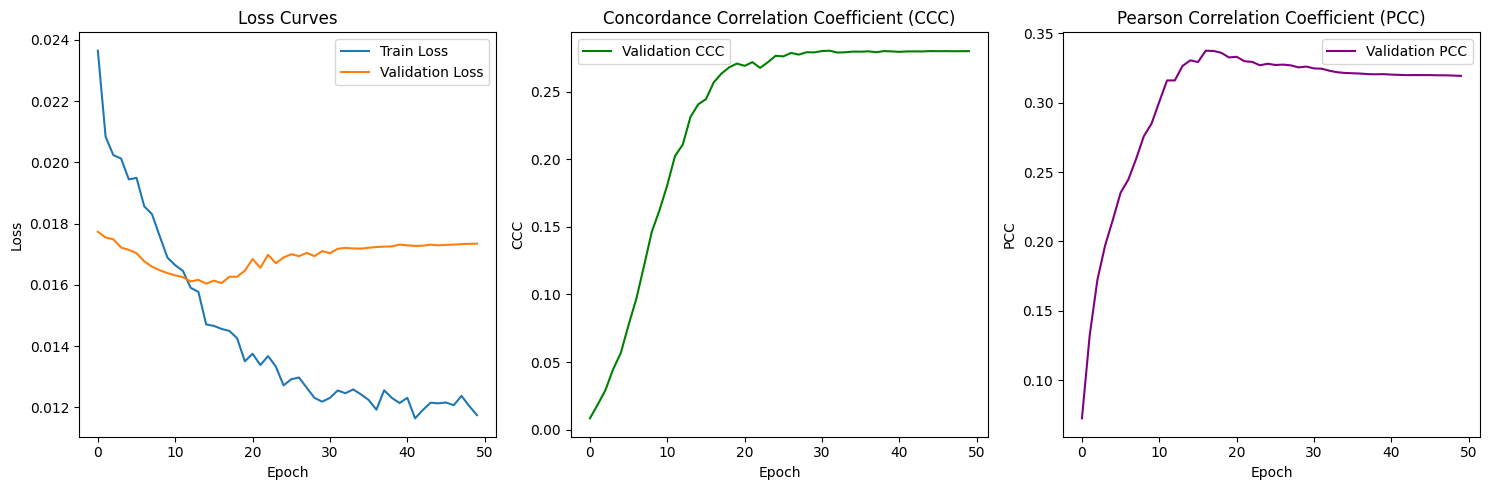

In [ ]:
# Final visualization
plt.figure(figsize=(15, 5))

# Plot 1: Loss curves
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

# Plot 2: CCC curve
plt.subplot(1, 3, 2)
plt.plot(val_cccs, label='Validation CCC', color='green')
plt.xlabel('Epoch')
plt.ylabel('CCC')
plt.legend()
plt.title('Concordance Correlation Coefficient (CCC)')

# Plot 3: PCC curve
plt.subplot(1, 3, 3)
plt.plot(val_pccs, label='Validation PCC', color='purple')
plt.xlabel('Epoch')
plt.ylabel('PCC')
plt.legend()
plt.title('Pearson Correlation Coefficient (PCC)')

plt.tight_layout()
plt.savefig('m2_video_audio.png')
plt.show()

In [16]:
# Load the best model for evaluation
if os.path.exists(best_model_path):
    checkpoint = torch.load(best_model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded best model from epoch {checkpoint['epoch']+1} with:")
    print(f"- Validation Loss: {checkpoint['val_loss']:.4f}")
    print(f"- Validation CCC: {checkpoint['val_ccc']:.4f}")
    print(f"- Validation PCC: {checkpoint['val_pcc']:.4f}")


Loaded best model from epoch 32 with:
- Validation Loss: 0.0172
- Validation CCC: 0.2803
- Validation PCC: 0.3245


# Test 3: Listener Openface + Listener Video + Speaker Speech

In [17]:
config = {
    'ckpt_root': './pretrained',
    'activation_fn': 'tanh',
    'extra_dropout': 0,
    'hidden_size': 8,
    'dropout': 0.2,
    'weight_decay': 0.01,
    'expnum': 8,
    'openfacefeat': 1,
    'openfacefeat_extramlp': 1,
    'openfacefeat_extramlp_dim': 8,
    'ablation': 8,
    'num_labels': 1
}

config = SimpleNamespace(**config)
model = EarlyFusion3(config=config, pooling_factor=8).to(device).float()
print(model)

print(f"Parameters:")
print(f"activation_fn: {config.activation_fn}")
print(f"hidden_size: {config.hidden_size}")
print(f"dropout: {config.dropout}")
print(f"weight_decay: {config.weight_decay}")
print(f"num_labels: {config.num_labels}")
print(f"pooling_factor: {model.pooling_factor}")

# Count trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {trainable_params}")


EarlyFusion3(
  (video_mlp): Sequential(
    (0): Linear(in_features=1024, out_features=8, bias=True)
    (1): Tanh()
  )
  (openface_mlp): Sequential(
    (0): Linear(in_features=329, out_features=8, bias=True)
    (1): Tanh()
  )
  (audio_mlp): Sequential(
    (0): Linear(in_features=768, out_features=8, bias=True)
    (1): Tanh()
  )
  (cross_attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=8, out_features=8, bias=True)
  )
  (fusion_mlp): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): Tanh()
  )
  (fusion_mlp2): Sequential(
    (0): Linear(in_features=192, out_features=64, bias=True)
    (1): Tanh()
  )
  (out): Classifier(
    (dropout): Dropout(p=0.2, inplace=False)
    (fc1): Linear(in_features=64, out_features=8, bias=True)
    (fc2): Linear(in_features=8, out_features=8, bias=True)
    (fc3): Linear(in_features=8, out_features=1, bias=True)
    (activation_fn): Tanh()
  )
)
Parameters:
activation_fn:

In [18]:
def compute_ccc_batched(y_pred, y_true):

    y_true_np = y_true.flatten()
    y_pred_np = y_pred.flatten()
    mean_true = np.mean(y_true_np)
    mean_pred = np.mean(y_pred_np)
    std_true = np.std(y_true_np)
    std_pred = np.std(y_pred_np)

    rho, _ = pearsonr(y_true_np, y_pred_np)

    # Calculate CCC
    ccc = (2 * rho * std_true * std_pred) / (std_true**2 + std_pred**2 + (mean_true - mean_pred)**2)
    
    return ccc

def compute_pearson_correlation_batched(y_pred, y_true):
 
    y_true_np = y_true.flatten()
    y_pred_np = y_pred.flatten()

    # Calculate PCC
    rho, _ = pearsonr(y_true_np, y_pred_np)

    return rho

In [19]:
# Training settings
num_epochs = 50
learning_rate = 1e-4
best_model_path = 'best_early_fusion_model3.pth'

criterion = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=config.weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)

# Training tracking
best_val_ccc = -float('inf')
no_improve_count = 0
train_losses = []
val_losses = []
val_cccs = []
val_pccs = []

d:\software\Anaconda\envs\eng_env\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [20]:
try:
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        # Training:
        model.train()
        total_train_loss = 0
        
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]", leave=False):

            listener_video_feat, listener_facial_feat, speaker_audio_feat = batch["features"]
            engagement = batch["score"]
            
            listener_video_feat = listener_video_feat.to(device).float()
            listener_facial_feat = listener_facial_feat.to(device).float()
            speaker_audio_feat = speaker_audio_feat.to(device).float()
            
            engagement = engagement.to(device)
            engagement = engagement.view(-1, 1)
            optimizer.zero_grad()
            
            # Create a list of listener features with transposed dimensions
            listener_facial_list = []
            for i in range(listener_facial_feat.size(0)):
                listener_facial_list.append(listener_facial_feat[i])
            
            output = model(audio_paths=speaker_audio_feat, openfacefeat_=listener_facial_list, video_paths=listener_video_feat)
            loss = criterion(output, engagement)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        
        # Calculate average training loss
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Training Loss: {avg_train_loss:.4f}")
        
        # Validation:
        model.eval()
        val_loss = 0
        val_preds = []
        val_targets = []
        
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]", leave=False):

                listener_video_feat, listener_facial_feat, speaker_audio_feat = batch["features"]
                engagement = batch["score"]
                
                listener_video_feat = listener_video_feat.to(device)
                listener_facial_feat = listener_facial_feat.to(device)
                speaker_audio_feat = speaker_audio_feat.to(device)
                engagement = engagement.to(device)
                engagement = engagement.view(-1, 1)

                # Create a list of listener features with transposed dimensions
                listener_facial_list = []
                for i in range(listener_facial_feat.size(0)):
                    listener_facial_list.append(listener_facial_feat[i])
                
                output = model(audio_paths=speaker_audio_feat, openfacefeat_=listener_facial_list, video_paths=listener_video_feat)
                loss = criterion(output, engagement)
                val_loss += loss.item() * engagement.size(0)
                
                # Store predictions and targets for metrics
                val_preds.append(output.cpu())
                val_targets.append(engagement.cpu())
        
        # Calculate average validation loss
        avg_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)
        
        # Calculate metrics
        val_preds_combined = torch.cat(val_preds).numpy()
        val_targets_combined = torch.cat(val_targets).numpy()
        
        val_ccc = compute_ccc_batched(val_preds_combined, val_targets_combined)
        val_pcc = compute_pearson_correlation_batched(val_preds_combined, val_targets_combined)
        
        val_cccs.append(val_ccc)
        val_pccs.append(val_pcc)
        
        print(f"Validation Loss: {avg_val_loss:.4f}, CCC: {val_ccc:.4f}, PCC: {val_pcc:.4f}")
        
        # Update learning rate
        scheduler.step(avg_val_loss)
        
        # Check if this is the best model
        if val_ccc > best_val_ccc:
            best_val_ccc = val_ccc
            # Save model
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': avg_val_loss,
                'val_ccc': val_ccc,
                'val_pcc': val_pcc,
                'config': config,
            }, best_model_path)
            print(f"✓ Saved new best model with validation CCC: {val_ccc:.4f}")

except KeyboardInterrupt:
    print("Training interrupted by user")

Epoch 1/50


Epoch 1 [Train]:   0%|          | 0/132 [00:00<?, ?it/s]

Training Loss: 0.0320


Validation Loss: 0.0183, CCC: 0.0648, PCC: 0.1137
✓ Saved new best model with validation CCC: 0.0648
Epoch 2/50


Training Loss: 0.0235


Validation Loss: 0.0173, CCC: 0.1126, PCC: 0.2062
✓ Saved new best model with validation CCC: 0.1126
Epoch 3/50


Training Loss: 0.0226


Validation Loss: 0.0165, CCC: 0.1585, PCC: 0.2799
✓ Saved new best model with validation CCC: 0.1585
Epoch 4/50


Training Loss: 0.0211


Validation Loss: 0.0160, CCC: 0.1979, PCC: 0.3166
✓ Saved new best model with validation CCC: 0.1979
Epoch 5/50


Training Loss: 0.0205


Validation Loss: 0.0158, CCC: 0.2160, PCC: 0.3479
✓ Saved new best model with validation CCC: 0.2160
Epoch 6/50


Training Loss: 0.0193


Validation Loss: 0.0156, CCC: 0.2375, PCC: 0.3595
✓ Saved new best model with validation CCC: 0.2375
Epoch 7/50


Training Loss: 0.0187


Validation Loss: 0.0156, CCC: 0.2582, PCC: 0.3774
✓ Saved new best model with validation CCC: 0.2582
Epoch 8/50


Training Loss: 0.0187


Validation Loss: 0.0152, CCC: 0.2822, PCC: 0.3905
✓ Saved new best model with validation CCC: 0.2822
Epoch 9/50


Training Loss: 0.0171


Validation Loss: 0.0150, CCC: 0.2932, PCC: 0.3990
✓ Saved new best model with validation CCC: 0.2932
Epoch 10/50


Training Loss: 0.0171


Validation Loss: 0.0147, CCC: 0.3274, PCC: 0.4206
✓ Saved new best model with validation CCC: 0.3274
Epoch 11/50


Training Loss: 0.0164


Validation Loss: 0.0147, CCC: 0.3266, PCC: 0.4229
Epoch 12/50


Training Loss: 0.0162


Validation Loss: 0.0146, CCC: 0.3483, PCC: 0.4349
✓ Saved new best model with validation CCC: 0.3483
Epoch 13/50


Training Loss: 0.0151


Validation Loss: 0.0145, CCC: 0.3559, PCC: 0.4423
✓ Saved new best model with validation CCC: 0.3559
Epoch 14/50


Training Loss: 0.0145


Validation Loss: 0.0146, CCC: 0.3600, PCC: 0.4460
✓ Saved new best model with validation CCC: 0.3600
Epoch 15/50


Training Loss: 0.0146


Validation Loss: 0.0149, CCC: 0.3552, PCC: 0.4481
Epoch 16/50


Training Loss: 0.0142


Validation Loss: 0.0145, CCC: 0.3669, PCC: 0.4468
✓ Saved new best model with validation CCC: 0.3669
Epoch 17/50


Training Loss: 0.0143


Validation Loss: 0.0142, CCC: 0.3864, PCC: 0.4635
✓ Saved new best model with validation CCC: 0.3864
Epoch 18/50


Training Loss: 0.0134


Validation Loss: 0.0144, CCC: 0.3826, PCC: 0.4496
Epoch 19/50


Training Loss: 0.0133


Validation Loss: 0.0141, CCC: 0.3786, PCC: 0.4584
Epoch 20/50


Training Loss: 0.0132


Validation Loss: 0.0145, CCC: 0.3894, PCC: 0.4643
✓ Saved new best model with validation CCC: 0.3894
Epoch 21/50


Training Loss: 0.0125


Validation Loss: 0.0143, CCC: 0.3786, PCC: 0.4509
Epoch 22/50


Training Loss: 0.0125


Validation Loss: 0.0144, CCC: 0.3997, PCC: 0.4591
✓ Saved new best model with validation CCC: 0.3997
Epoch 23/50


Training Loss: 0.0128


Validation Loss: 0.0142, CCC: 0.3969, PCC: 0.4661
Epoch 24/50


Training Loss: 0.0125


Validation Loss: 0.0142, CCC: 0.4129, PCC: 0.4707
✓ Saved new best model with validation CCC: 0.4129
Epoch 25/50


Training Loss: 0.0119


Validation Loss: 0.0142, CCC: 0.4044, PCC: 0.4649
Epoch 26/50


Training Loss: 0.0117


Validation Loss: 0.0144, CCC: 0.4127, PCC: 0.4656
Epoch 27/50


Training Loss: 0.0112


Validation Loss: 0.0145, CCC: 0.4171, PCC: 0.4691
✓ Saved new best model with validation CCC: 0.4171
Epoch 28/50


Training Loss: 0.0113


Validation Loss: 0.0143, CCC: 0.4168, PCC: 0.4684
Epoch 29/50


Training Loss: 0.0112


Validation Loss: 0.0143, CCC: 0.4190, PCC: 0.4703
✓ Saved new best model with validation CCC: 0.4190
Epoch 30/50


Training Loss: 0.0111


Validation Loss: 0.0143, CCC: 0.4234, PCC: 0.4712
✓ Saved new best model with validation CCC: 0.4234
Epoch 31/50


Training Loss: 0.0110


Validation Loss: 0.0144, CCC: 0.4202, PCC: 0.4686
Epoch 32/50


Training Loss: 0.0109


Validation Loss: 0.0144, CCC: 0.4237, PCC: 0.4690
✓ Saved new best model with validation CCC: 0.4237
Epoch 33/50


Training Loss: 0.0108


Validation Loss: 0.0145, CCC: 0.4255, PCC: 0.4701
✓ Saved new best model with validation CCC: 0.4255
Epoch 34/50


Training Loss: 0.0106


Validation Loss: 0.0145, CCC: 0.4238, PCC: 0.4694
Epoch 35/50


Training Loss: 0.0105


Validation Loss: 0.0147, CCC: 0.4241, PCC: 0.4733
Epoch 36/50


Training Loss: 0.0104


Validation Loss: 0.0145, CCC: 0.4263, PCC: 0.4719
✓ Saved new best model with validation CCC: 0.4263
Epoch 37/50


Training Loss: 0.0104


Validation Loss: 0.0144, CCC: 0.4281, PCC: 0.4716
✓ Saved new best model with validation CCC: 0.4281
Epoch 38/50


Training Loss: 0.0103


Validation Loss: 0.0144, CCC: 0.4277, PCC: 0.4714
Epoch 39/50


Training Loss: 0.0105


Validation Loss: 0.0144, CCC: 0.4297, PCC: 0.4725
✓ Saved new best model with validation CCC: 0.4297
Epoch 40/50


Training Loss: 0.0105


Validation Loss: 0.0144, CCC: 0.4295, PCC: 0.4721
Epoch 41/50


Training Loss: 0.0103


Validation Loss: 0.0144, CCC: 0.4316, PCC: 0.4734
✓ Saved new best model with validation CCC: 0.4316
Epoch 42/50


Training Loss: 0.0104


Validation Loss: 0.0144, CCC: 0.4316, PCC: 0.4724
Epoch 43/50


Training Loss: 0.0101


Validation Loss: 0.0144, CCC: 0.4288, PCC: 0.4700
Epoch 44/50


Training Loss: 0.0102


Validation Loss: 0.0146, CCC: 0.4289, PCC: 0.4715
Epoch 45/50


Training Loss: 0.0099


Validation Loss: 0.0145, CCC: 0.4307, PCC: 0.4711
Epoch 46/50


Training Loss: 0.0098


Validation Loss: 0.0145, CCC: 0.4309, PCC: 0.4707
Epoch 47/50


Training Loss: 0.0104


Validation Loss: 0.0146, CCC: 0.4306, PCC: 0.4714
Epoch 48/50


Training Loss: 0.0099


Validation Loss: 0.0146, CCC: 0.4295, PCC: 0.4705
Epoch 49/50


Training Loss: 0.0098


Validation Loss: 0.0145, CCC: 0.4314, PCC: 0.4706
Epoch 50/50


Training Loss: 0.0102


Validation Loss: 0.0145, CCC: 0.4305, PCC: 0.4703


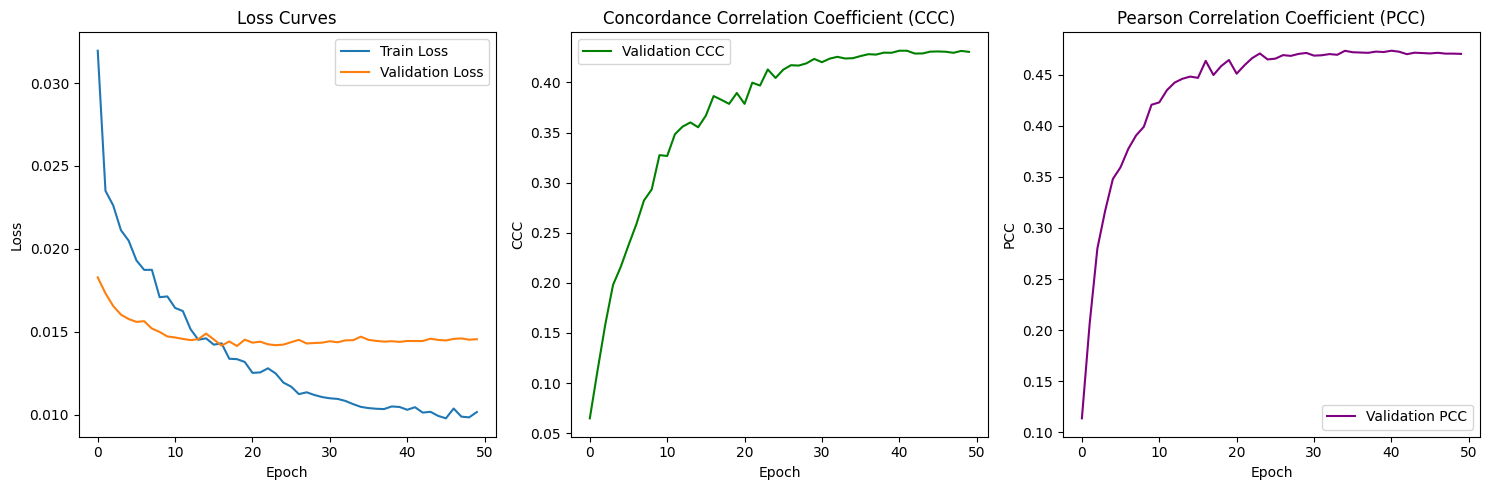

In [ ]:
# Final visualization
plt.figure(figsize=(15, 5))

# Plot 1: Loss curves
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

# Plot 2: CCC curve
plt.subplot(1, 3, 2)
plt.plot(val_cccs, label='Validation CCC', color='green')
plt.xlabel('Epoch')
plt.ylabel('CCC')
plt.legend()
plt.title('Concordance Correlation Coefficient (CCC)')

# Plot 3: PCC curve
plt.subplot(1, 3, 3)
plt.plot(val_pccs, label='Validation PCC', color='purple')
plt.xlabel('Epoch')
plt.ylabel('PCC')
plt.legend()
plt.title('Pearson Correlation Coefficient (PCC)')

plt.tight_layout()
plt.savefig('m2_video_openface_audio.png')
plt.show()

In [22]:
# Load the best model for evaluation
if os.path.exists(best_model_path):
    checkpoint = torch.load(best_model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded best model from epoch {checkpoint['epoch']+1} with:")
    print(f"- Validation Loss: {checkpoint['val_loss']:.4f}")
    print(f"- Validation CCC: {checkpoint['val_ccc']:.4f}")
    print(f"- Validation PCC: {checkpoint['val_pcc']:.4f}")


Loaded best model from epoch 41 with:
- Validation Loss: 0.0144
- Validation CCC: 0.4316
- Validation PCC: 0.4734


# ListenerSpeakerHybridFusionSampling

In [23]:
config = { 'activation_fn': 'Tanh',
           'extra_dropout':0 ,
             'hidden_size':8,
             'dropout': 0.2,
             'weight_decay': 0.01,
             'num_labels': 1}

config = SimpleNamespace(**config)
model = ListenerSpeakerHybridFusionSampling(config=config, pooling_factor=8).to(device).float()
print(model)

print(f"Parameters:")
print(f"activation_fn: {config.activation_fn}")
print(f"hidden_size: {config.hidden_size}")
print(f"dropout: {config.dropout}")
print(f"weight_decay: {config.weight_decay}")
print(f"num_labels: {config.num_labels}")
print(f"pooling_factor: {model.pooling_factor}")

# Count trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {trainable_params}")


ListenerSpeakerHybridFusionSampling(
  (mlp): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
  )
  (mlp_norm): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
  (listener_proj): Sequential(
    (0): Linear(in_features=1024, out_features=8, bias=True)
    (1): Flatten(start_dim=1, end_dim=-1)
  )
  (speaker_proj): Sequential(
    (0): Linear(in_features=768, out_features=8, bias=True)
    (1): Flatten(start_dim=1, end_dim=-1)
  )
  (cross_attention): CrossAttention(
    (attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
    )
  )
  (attn_norm): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
  (classifier): Linear(in_features=64, out_features=1, bias=True)
  (activation_fn): Tanh()
)
Parameters:
activation_fn: Tanh
hidden_size: 8
dropout: 0.2
weight_decay: 0.01
num_labels: 1
pooling_factor: 8
Total trainable parameters: 39345


In [24]:
def compute_ccc_batched(y_pred, y_true):

    y_true_np = y_true.flatten()
    y_pred_np = y_pred.flatten()
    mean_true = np.mean(y_true_np)
    mean_pred = np.mean(y_pred_np)
    std_true = np.std(y_true_np)
    std_pred = np.std(y_pred_np)

    rho, _ = pearsonr(y_true_np, y_pred_np)

    # Calculate CCC
    ccc = (2 * rho * std_true * std_pred) / (std_true**2 + std_pred**2 + (mean_true - mean_pred)**2)
    
    return ccc

import numpy as np
from scipy.stats import pearsonr

def compute_pearson_correlation_batched(y_pred, y_true):
 
    y_true_np = y_true.flatten()
    y_pred_np = y_pred.flatten()

    # Calculate PCC
    rho, _ = pearsonr(y_true_np, y_pred_np)

    return rho

In [25]:
# Training settings
num_epochs = 50
learning_rate = 1e-4
best_model_path = 'best_early_fusion_model4.pth'

criterion = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=config.weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)

# Training tracking
best_val_ccc = -float('inf')
no_improve_count = 0
train_losses = []
val_losses = []
val_cccs = []
val_pccs = []

d:\software\Anaconda\envs\eng_env\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [26]:
try:
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        # Training:
        model.train()
        total_train_loss = 0
        
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]", leave=False):

            listener_feat, _, speaker_feat = batch["features"]
            engagement = batch["score"]
            
            speaker_feat = speaker_feat.to(device).float()
            listener_feat = listener_feat.to(device).float()
            engagement = engagement.to(device)
            engagement = engagement.view(-1, 1)
            optimizer.zero_grad()
            
            # Create a list of listener features with transposed dimensions
            listener_feat_list = []
            for i in range(listener_feat.size(0)):
                listener_feat_list.append(listener_feat[i].transpose(0, 1))
            
            #output = model(audio_paths=speaker_feat, video_paths=listener_feat_list)
            output = model(speaker_feats=speaker_feat, listener_feats=listener_feat)
            loss = criterion(output, engagement)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        
        # Calculate average training loss
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Training Loss: {avg_train_loss:.4f}")
        
        # Validation:
        model.eval()
        val_loss = 0
        val_preds = []
        val_targets = []
        
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]", leave=False):

                listener_feat, _, speaker_feat = batch["features"]
                engagement = batch["score"]
                
                speaker_feat = speaker_feat.to(device)
                listener_feat = listener_feat.to(device)
                engagement = engagement.to(device)
                engagement = engagement.view(-1, 1)

                # Create a list of listener features with transposed dimensions
                listener_feat_list = []
                for i in range(listener_feat.size(0)):
                    listener_feat_list.append(listener_feat[i].transpose(0, 1))
                
                #output = model(audio_paths=speaker_feat, video_paths=listener_feat_list)
                output = model(speaker_feats=speaker_feat, listener_feats=listener_feat)
                loss = criterion(output, engagement)
                val_loss += loss.item() * engagement.size(0)
                
                # Store predictions and targets for metrics
                val_preds.append(output.cpu())
                val_targets.append(engagement.cpu())
        
        # Calculate average validation loss
        avg_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)
        
        # Calculate metrics
        val_preds_combined = torch.cat(val_preds).numpy()
        val_targets_combined = torch.cat(val_targets).numpy()
        
        val_ccc = compute_ccc_batched(val_preds_combined, val_targets_combined)
        val_pcc = compute_pearson_correlation_batched(val_preds_combined, val_targets_combined)
        
        val_cccs.append(val_ccc)
        val_pccs.append(val_pcc)
        
        print(f"Validation Loss: {avg_val_loss:.4f}, CCC: {val_ccc:.4f}, PCC: {val_pcc:.4f}")
        
        # Update learning rate
        scheduler.step(avg_val_loss)
        
        # Check if this is the best model
        if val_ccc > best_val_ccc:
            best_val_ccc = val_ccc
            # Save model
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': avg_val_loss,
                'val_ccc': val_ccc,
                'val_pcc': val_pcc,
                'config': config,
            }, best_model_path)
            print(f"✓ Saved new best model with validation CCC: {val_ccc:.4f}")

except KeyboardInterrupt:
    print("Training interrupted by user")

Epoch 1/50


Epoch 1 [Train]:   0%|          | 0/132 [00:00<?, ?it/s]

Training Loss: 0.0203


Validation Loss: 0.0182, CCC: 0.0364, PCC: 0.0805
✓ Saved new best model with validation CCC: 0.0364
Epoch 2/50


Training Loss: 0.0180


Validation Loss: 0.0178, CCC: 0.0585, PCC: 0.1305
✓ Saved new best model with validation CCC: 0.0585
Epoch 3/50


Training Loss: 0.0171


Validation Loss: 0.0176, CCC: 0.0832, PCC: 0.1702
✓ Saved new best model with validation CCC: 0.0832
Epoch 4/50


Training Loss: 0.0163


Validation Loss: 0.0173, CCC: 0.1170, PCC: 0.2021
✓ Saved new best model with validation CCC: 0.1170
Epoch 5/50


Training Loss: 0.0155


Validation Loss: 0.0174, CCC: 0.1398, PCC: 0.2162
✓ Saved new best model with validation CCC: 0.1398
Epoch 6/50


Training Loss: 0.0148


Validation Loss: 0.0174, CCC: 0.1655, PCC: 0.2401
✓ Saved new best model with validation CCC: 0.1655
Epoch 7/50


Training Loss: 0.0142


Validation Loss: 0.0174, CCC: 0.1874, PCC: 0.2553
✓ Saved new best model with validation CCC: 0.1874
Epoch 8/50


Training Loss: 0.0138


Validation Loss: 0.0175, CCC: 0.1997, PCC: 0.2644
✓ Saved new best model with validation CCC: 0.1997
Epoch 9/50


Training Loss: 0.0133


Validation Loss: 0.0175, CCC: 0.2159, PCC: 0.2693
✓ Saved new best model with validation CCC: 0.2159
Epoch 10/50


Training Loss: 0.0130


Validation Loss: 0.0175, CCC: 0.2140, PCC: 0.2674
Epoch 11/50


Training Loss: 0.0123


Validation Loss: 0.0176, CCC: 0.2300, PCC: 0.2779
✓ Saved new best model with validation CCC: 0.2300
Epoch 12/50


Training Loss: 0.0121


Validation Loss: 0.0177, CCC: 0.2303, PCC: 0.2754
✓ Saved new best model with validation CCC: 0.2303
Epoch 13/50


Training Loss: 0.0120


Validation Loss: 0.0178, CCC: 0.2382, PCC: 0.2793
✓ Saved new best model with validation CCC: 0.2382
Epoch 14/50


Training Loss: 0.0118


Validation Loss: 0.0179, CCC: 0.2428, PCC: 0.2832
✓ Saved new best model with validation CCC: 0.2428
Epoch 15/50


Training Loss: 0.0117


Validation Loss: 0.0179, CCC: 0.2485, PCC: 0.2865
✓ Saved new best model with validation CCC: 0.2485
Epoch 16/50


Training Loss: 0.0115


Validation Loss: 0.0181, CCC: 0.2464, PCC: 0.2850
Epoch 17/50


Training Loss: 0.0113


Validation Loss: 0.0180, CCC: 0.2485, PCC: 0.2846
Epoch 18/50


Training Loss: 0.0112


Validation Loss: 0.0180, CCC: 0.2520, PCC: 0.2867
✓ Saved new best model with validation CCC: 0.2520
Epoch 19/50


Training Loss: 0.0111


Validation Loss: 0.0181, CCC: 0.2514, PCC: 0.2858
Epoch 20/50


Training Loss: 0.0111


Validation Loss: 0.0181, CCC: 0.2532, PCC: 0.2864
✓ Saved new best model with validation CCC: 0.2532
Epoch 21/50


Training Loss: 0.0110


Validation Loss: 0.0182, CCC: 0.2533, PCC: 0.2864
✓ Saved new best model with validation CCC: 0.2533
Epoch 22/50


Training Loss: 0.0109


Validation Loss: 0.0182, CCC: 0.2557, PCC: 0.2870
✓ Saved new best model with validation CCC: 0.2557
Epoch 23/50


Training Loss: 0.0109


Validation Loss: 0.0182, CCC: 0.2555, PCC: 0.2865
Epoch 24/50


Training Loss: 0.0108


Validation Loss: 0.0183, CCC: 0.2556, PCC: 0.2865
Epoch 25/50


Training Loss: 0.0108


Validation Loss: 0.0183, CCC: 0.2556, PCC: 0.2865
Epoch 26/50


Training Loss: 0.0108


Validation Loss: 0.0183, CCC: 0.2560, PCC: 0.2866
✓ Saved new best model with validation CCC: 0.2560
Epoch 27/50


Training Loss: 0.0107


Validation Loss: 0.0184, CCC: 0.2547, PCC: 0.2858
Epoch 28/50


Training Loss: 0.0107


Validation Loss: 0.0183, CCC: 0.2572, PCC: 0.2867
✓ Saved new best model with validation CCC: 0.2572
Epoch 29/50


Training Loss: 0.0106


Validation Loss: 0.0184, CCC: 0.2571, PCC: 0.2871
Epoch 30/50


Training Loss: 0.0106


Validation Loss: 0.0184, CCC: 0.2571, PCC: 0.2868
Epoch 31/50


Training Loss: 0.0106


Validation Loss: 0.0184, CCC: 0.2576, PCC: 0.2869
✓ Saved new best model with validation CCC: 0.2576
Epoch 32/50


Training Loss: 0.0106


Validation Loss: 0.0184, CCC: 0.2573, PCC: 0.2865
Epoch 33/50


Training Loss: 0.0106


Validation Loss: 0.0184, CCC: 0.2574, PCC: 0.2865
Epoch 34/50


Training Loss: 0.0106


Validation Loss: 0.0184, CCC: 0.2571, PCC: 0.2862
Epoch 35/50


Training Loss: 0.0106


Validation Loss: 0.0184, CCC: 0.2576, PCC: 0.2865
✓ Saved new best model with validation CCC: 0.2576
Epoch 36/50


Training Loss: 0.0105


Validation Loss: 0.0184, CCC: 0.2576, PCC: 0.2865
✓ Saved new best model with validation CCC: 0.2576
Epoch 37/50


Training Loss: 0.0105


Validation Loss: 0.0184, CCC: 0.2578, PCC: 0.2866
✓ Saved new best model with validation CCC: 0.2578
Epoch 38/50


Training Loss: 0.0105


Validation Loss: 0.0184, CCC: 0.2579, PCC: 0.2866
✓ Saved new best model with validation CCC: 0.2579
Epoch 39/50


Training Loss: 0.0105


Validation Loss: 0.0184, CCC: 0.2579, PCC: 0.2866
✓ Saved new best model with validation CCC: 0.2579
Epoch 40/50


Training Loss: 0.0105


Validation Loss: 0.0184, CCC: 0.2583, PCC: 0.2869
✓ Saved new best model with validation CCC: 0.2583
Epoch 41/50


Training Loss: 0.0105


Validation Loss: 0.0184, CCC: 0.2582, PCC: 0.2868
Epoch 42/50


Training Loss: 0.0105


Validation Loss: 0.0184, CCC: 0.2581, PCC: 0.2867
Epoch 43/50


Training Loss: 0.0105


Validation Loss: 0.0184, CCC: 0.2582, PCC: 0.2867
Epoch 44/50


Training Loss: 0.0105


Validation Loss: 0.0185, CCC: 0.2582, PCC: 0.2867
Epoch 45/50


Training Loss: 0.0105


Validation Loss: 0.0185, CCC: 0.2583, PCC: 0.2867
✓ Saved new best model with validation CCC: 0.2583
Epoch 46/50


Training Loss: 0.0105


Validation Loss: 0.0185, CCC: 0.2583, PCC: 0.2867
✓ Saved new best model with validation CCC: 0.2583
Epoch 47/50


Training Loss: 0.0105


Validation Loss: 0.0185, CCC: 0.2583, PCC: 0.2867
Epoch 48/50


Training Loss: 0.0105


Validation Loss: 0.0185, CCC: 0.2584, PCC: 0.2867
✓ Saved new best model with validation CCC: 0.2584
Epoch 49/50


Training Loss: 0.0105


Validation Loss: 0.0185, CCC: 0.2583, PCC: 0.2867
Epoch 50/50


Training Loss: 0.0104


Validation Loss: 0.0185, CCC: 0.2584, PCC: 0.2867


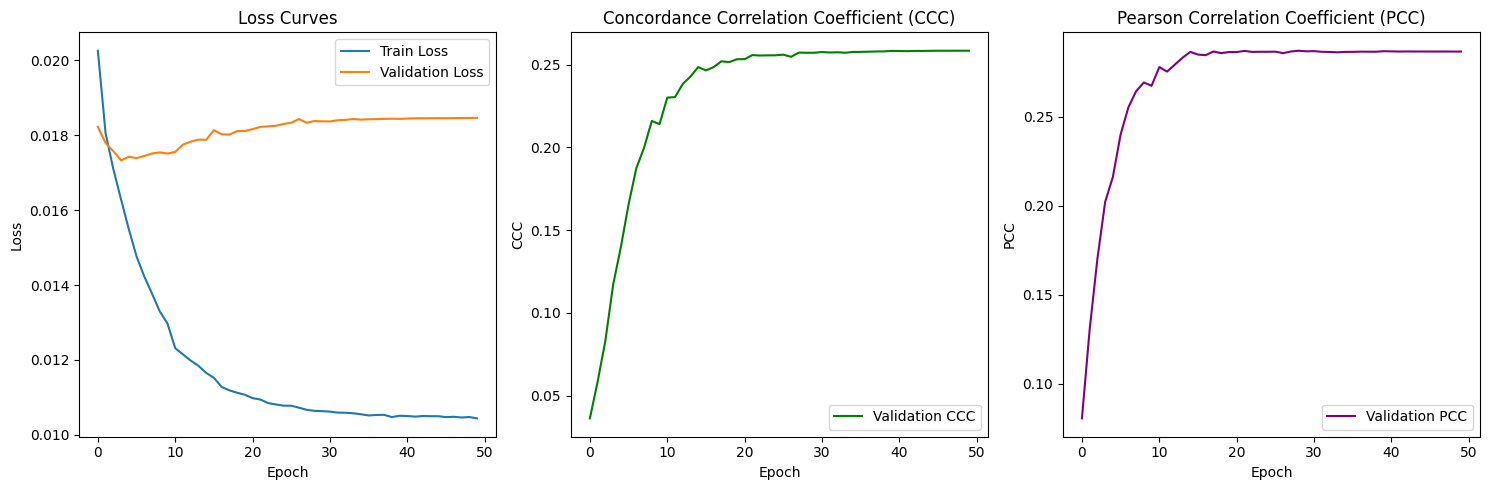

In [27]:
# Final visualization
plt.figure(figsize=(15, 5))

# Plot 1: Loss curves
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

# Plot 2: CCC curve
plt.subplot(1, 3, 2)
plt.plot(val_cccs, label='Validation CCC', color='green')
plt.xlabel('Epoch')
plt.ylabel('CCC')
plt.legend()
plt.title('Concordance Correlation Coefficient (CCC)')

# Plot 3: PCC curve
plt.subplot(1, 3, 3)
plt.plot(val_pccs, label='Validation PCC', color='purple')
plt.xlabel('Epoch')
plt.ylabel('PCC')
plt.legend()
plt.title('Pearson Correlation Coefficient (PCC)')

plt.tight_layout()
plt.savefig('m1_video_audio.png')
plt.show()

In [28]:
# Load the best model for evaluation
if os.path.exists(best_model_path):
    checkpoint = torch.load(best_model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded best model from epoch {checkpoint['epoch']+1} with:")
    print(f"- Validation Loss: {checkpoint['val_loss']:.4f}")
    print(f"- Validation CCC: {checkpoint['val_ccc']:.4f}")
    print(f"- Validation PCC: {checkpoint['val_pcc']:.4f}")


Loaded best model from epoch 48 with:
- Validation Loss: 0.0185
- Validation CCC: 0.2584
- Validation PCC: 0.2867
